# Exploring Thomas Fire Using Satellite Imagery

**Author**: Kat Le

**Github Repository**: https://github.com/katleyq/eds220-hwk4

### About this notebook

The purpose of this analysis is to demonstrate how to use landsat data to identify areas that have been affected by wildfire. We will explore different spectral bands of landsat data to see if we can identify areas of Santa Barbara County that were burned by the Thomas Fire in Santa Barbara County in 2017. We will compare the results of the raster analysis to the official Thomas Fire Perimeter vector data.  

### Highlights

This notebook will demonstrate the following:

- Identify areas affected by wildfire using remote sensing data
- Work with NetCDF files containing spatial data
- Compare and contrast insights gained from true versus false color satellite images


### Data Sources
This notebook utilizes the following datasets:

1) **Thomas Fire Perimeter Data**: [California Fire Perimeter Data](https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436)

    **Description** : This dataset contains geospatial information for the 2017 Thomas Fire in Santa Barbara County, California. Included is a polygon of the Thomas Fire perimeter and associated metadata. This data was obtained from the California Department of Forestry and Fire Protection's (CAL FIRE) California Fire Perimeter dataset.


2) **Landsat Data**: [Microsoft Planetary Computer Data Catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)

    **Description** : This Landsat dataset provides multispectral satellite imagery from the Landsat Collection 2, Level-2 archive. It contains surface reflectance of the Santa Barbara County area following the 2017 Thomas Fire. This data is managed by the U.S. Geological Survey (USGS), and is hosted on the Microsoft Planetary Computer Data Catalogue.

### Import libraries and load data


In [1]:
import os # To construct file paths
import xarray as xr # To work with arrays
import rioxarray as rioxr # To work with netCDFs
import geopandas as gpd # To maniplate spatial data frames
from shapely.geometry import box  # To create polygon bounding box
import matplotlib.pyplot as plt # To plot spatial data
from matplotlib_scalebar.scalebar import ScaleBar # for map scalebar
import matplotlib.patches as mpatches # for map legend
from matplotlib.offsetbox import AnchoredText # for map compass

In [2]:
# Create path to repository data folder
data_folder_fp = os.path.join(#'/',
                              #'Users',
                              #'katherine', 
                              #'MEDS',
                              #'EDS-220',
                              #'eds220-hwk4',
                              'data')

# Load California Fire Perimeter shapefile
thomas_fire = gpd.read_file(f"{data_folder_fp}/thomas_fire.shp")

# Load landsat data
landsat = rioxr.open_rasterio(f"{data_folder_fp}/landsat8-2018-01-26-sb-simplified.nc")

### View landsat data

In [3]:
# View landsat data
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

After viewing landsat data, we can see there is a band dimension where the only value is 1. Since the only value is 1, it is better to remove the band dimension. We can do that by squeezing the data into 2 dimensions then dropping the band variable.

In [4]:
# Convert data to 2 dimensions then drop the band variable
landsat = landsat.squeeze().drop_vars('band')

## Preliminary data exploration

As with any data object, it is important to check attributes to learn more about the data and to see if it is what you expected. In this section, we'll look at the CRS of both data objects. We'll also look at the coordinates, dimensions, height, and width of the landsat data. We'll use the height and width to calculate an appropriate aspect ratio for plotting.

In [5]:
# Print out CRS of landsat and thomas_fire CRSs
print(f"**Landsat CRS** = {landsat.rio.crs}")
print('----')
print(f"**Thomas Fire CRS** = {thomas_fire.crs}")

**Landsat CRS** = EPSG:32611
----
**Thomas Fire CRS** = EPSG:3857


In [6]:
# Convert landsat data to array for exploration
landsat_array = landsat.to_array()

In [7]:
# Look at coordinates of landsat
landsat_array.coords

Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
  * variable     (variable) object 40B 'red' 'green' 'blue' 'nir08' 'swir22'

In [8]:
# Look at dimensions of landsat
landsat_array.dims

('variable', 'y', 'x')

In [9]:
# Look at shapes of landsat
landsat_array.shape

(5, 731, 870)

In [10]:
# Print the height and width of the landsat data 
print('Height: ', landsat.rio.height)
print('Width: ', landsat.rio.width)

Height:  731
Width:  870


In [11]:
# Calculate aspect ratio for plotting landsat data
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height

### Summary of data exploration
The exploratory analysis above indicates the following:
- The CRSs of landsat and thomas_fire do not match. We will need to convert one to match the other
- There are 5 variables: red, green, blue, nir08, and swir22
- Each array has a height of 731 and width of 870. We used these values to calculate the aspect ratio for future plotting

### Make sure CRS of both spatial objects match!
One of the most important steps of working with spatial data is to make sure that the CRSs match. From the exploration above, we know the CRS of both objects do not match. We'll convert the thomas_fire data to match the CRS of the landsat data. Then we'll construct an assert statement to ensure both objects have the same CRS before moving forward.

In [12]:
# Convert thomas_fire CRS to match landsat CRS
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

In [13]:
# Verify that landsat CRS is the same as thomas_fire crs before moving onto next code
assert landsat.rio.crs == thomas_fire.crs

### Create true color image of landsat data

Generating a true color image means that we are mapping red, green, and blue values to the red, green and blue channels, respectively. This creates a picture that is similar to how humans perceive color in an image. This can be helpful when you want to display data like how a human would naturally see it.

First, the true color image will be plotted without adjusting for RGB outliers. Then, the RGB values will be adjusted to account for outliers.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Figure 1a: This is a true color image with red, green and blue bands in the respect red, green, and blue channels. In this image, the scale for RGB values is not adjusted for clouds.')

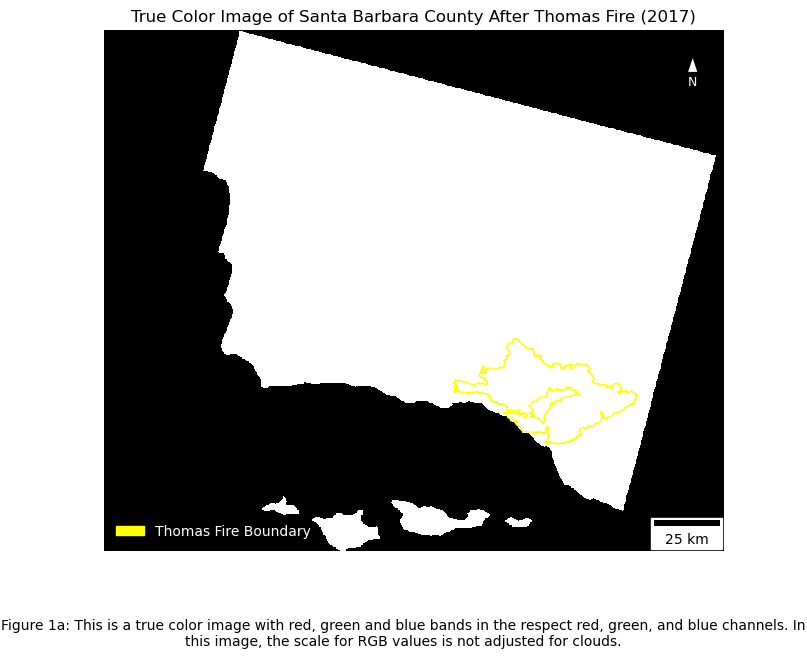

In [18]:
# Initialize a new plot
fig, ax = plt.subplots(figsize = (8, 6*landsat_aspect_ratio))

# Remove axes
ax.axis('off')

# Plot RGB values in respective RGB channels to display true color image
xr.Dataset(landsat[['red', 'green', 'blue']]).to_array().plot.imshow()

# Set title
ax.set_title('True Color Image of Santa Barbara County After Thomas Fire (2017)')

# Overlay thomas_fire polygon
thomas_fire.plot(ax = ax,
                 color = 'none',
                edgecolor = 'yellow', 
                linewidth = 1)
# Add scalebar
scalebar = ScaleBar(1,  # Scale in units per pixel
                    units='m',  # Units (meters)
                    location='lower right',  # Position of the scale bar
                    scale_loc='bottom') 

# Add scalebar created above to plot
ax.add_artist(scalebar)

# Add legend for thomas_fire boundary
ax.legend(handles = [mpatches.Patch(color='yellow',
                          label='Thomas Fire Boundary')], 
          loc = "lower left",
          labelcolor = "white", 
          frameon=False)

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.9),
            arrowprops=dict(facecolor='white', width=1, headwidth=8),
            ha='center', va='center', fontsize=9, color='white',
            xycoords='axes fraction')

# Add figure description
plt.figtext(0.5, 0, "Figure 1a: This is a true color image with red, green and blue bands in the respect red, green, and blue channels. In this image, the scale for RGB values is not adjusted for clouds.", wrap=True, horizontalalignment='center', fontsize=10)

Text(0.5, 0, 'Figure 1b: This is a true color image with red, green and blue bands in the respective red, green, and blue channels. In this image, robust is set to true, which adjusts RGB values to account for outliers due to clouds.')

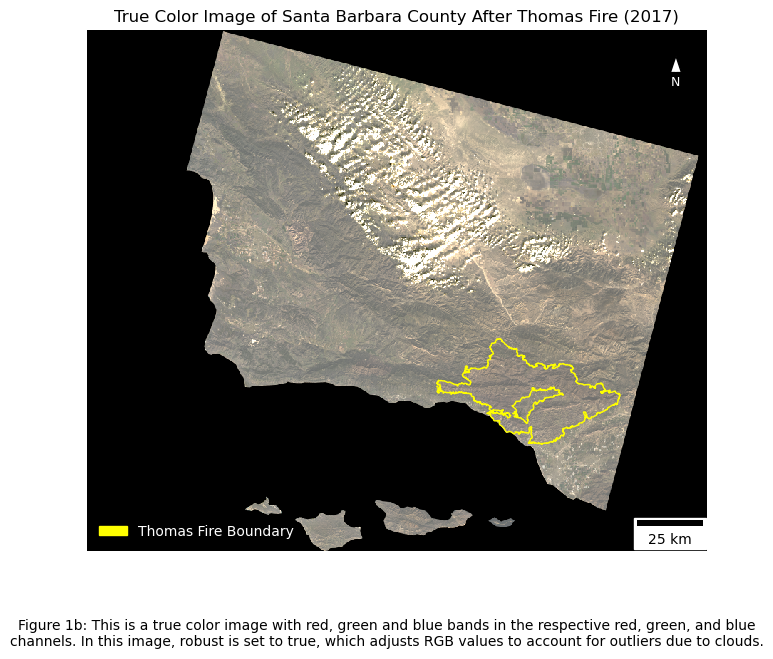

In [19]:
# Initialize a new plot
fig, ax = plt.subplots(figsize = (8, 6*landsat_aspect_ratio))

# Remove axes
ax.axis('off')

# Plot RGB values in respective RGB channels and adjust values to correct outliers from clouds
xr.Dataset(landsat[['red', 'green', 'blue']]).to_array().plot.imshow(robust = True)

ax.set_title('True Color Image of Santa Barbara County After Thomas Fire (2017)')

# Overlay thomas_fire polygon
thomas_fire.plot(ax = ax,
                 color = 'none',
                edgecolor = 'yellow', 
                linewidth = 1)

# Create scale bar specifications
scalebar = ScaleBar(1,  # Scale in units per pixel
                    units='m',  # units (meters)
                    location='lower right',  # Position of the scale bar
                    scale_loc='bottom')  

# Add scalebar created above to plot
ax.add_artist(scalebar)

# Create a legend for thomas_fire boundary
ax.legend(handles = [mpatches.Patch(color='yellow',
                          label='Thomas Fire Boundary')], 
          loc = "lower left",
          labelcolor = "white", 
          frameon=False)

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.9),
            arrowprops=dict(facecolor='white', width=1, headwidth=8),
            ha='center', va='center', fontsize=9, color='white',
            xycoords='axes fraction')

# Add figure description
plt.figtext(0.5, 0, "Figure 1b: This is a true color image with red, green and blue bands in the respective red, green, and blue channels. In this image, robust is set to true, which adjusts RGB values to account for outliers due to clouds.", wrap=True, horizontalalignment='center', fontsize=10)


## Difference between Figure 1A and 1B
Both Figure 1A and 1B are true color images of SB county landsat data, which means RGB values are in the respective RGB channels. The difference between the two figures is that Figure 1A is not adjusted for outliers. Due to moderate cloud cover during the timespan this data was captured, there are significantly higher RGB values where there are clouds. This is because clouds reflect light across red, green, and blue wavelengths. This causes outliers and inteferes with the scale of RGB values, which is why it is hard to see land reflectance. Figure 1B adjusts for these outliers due to clouds by normalizing the scale.


## Creating false color image of landsat data
False color images can provide more insights into what is happening in a given area. In this section, the short-wave infrared, near-infrared, and red bands are mapped to the red, green, and blue channels, respectively. This particular arrangement of spectral bands highlights the moisture content and vegetation health of the area, which can indicate if an area has been burned (Source: [NASA Earth Observatory](https://earthobservatory.nasa.gov/features/FalseColor)). The goal is to see if mapping the spectral bands this way will show the Thomas Fire burn scar better.

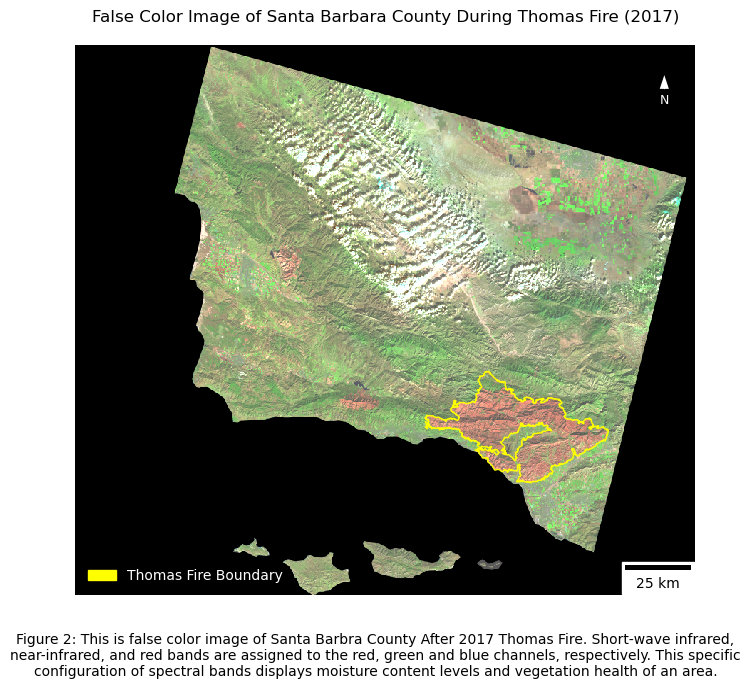

In [16]:
# Initialize a new plot with correct aspect ratio
fig, ax = plt.subplots(figsize = (8, 6*landsat_aspect_ratio))

# Remove axes
ax.axis('off')

# Overlay thomas_fire polygon
thomas_fire.plot(ax = ax,
                 color = 'none',
                edgecolor = 'yellow', 
                linewidth = 1)

# Plot shortwave infrared, near infrared, and red bands of landsat data to RGB channels respectively
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, 
                                                           robust = True)
# Add title
ax.set_title('False Color Image of Santa Barbara County During Thomas Fire (2017)')

# Create scalebar
scalebar = ScaleBar(1,  # Scale in units per pixel
                    units='m',  # Set units to meters
                    location='lower right', 
                    scale_loc='bottom')  

# Add scalebar created above to plot
ax.add_artist(scalebar)

# Create legend for Thomas Fire Boundary
ax.legend(handles = [mpatches.Patch(color='yellow',
                          label='Thomas Fire Boundary')], 
          loc = "lower left",
          labelcolor = "white", 
          frameon=False)

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.9),
            arrowprops=dict(facecolor='white', width=1, headwidth=8),
            ha='center', va='center', fontsize=9, color='white',
            xycoords='axes fraction')

# Add figure description
plt.figtext(0.5, 0, "Figure 2: This is false color image of Santa Barbra County After 2017 Thomas Fire. Short-wave infrared, near-infrared, and red bands are assigned to the red, green and blue channels, respectively. This specific configuration of spectral bands displays moisture content levels and vegetation health of an area.", wrap=True, horizontalalignment='center', fontsize=10)


plt.show()

### Taking a closer look at Thomas Fire perimeter

In this section, the thomas_fire polygon was used to clip the landsat data. The result was plotted to show a zoomed-in view of the false color image generated above. It was interesting to see that within the Thomas Fire perimeter, there were many pockets of land that did not appear to be burned.

Text(0.5, 0, 'Figure 3: The landsat data was clipped to only show area within Thomas Fire Burn Scar.')

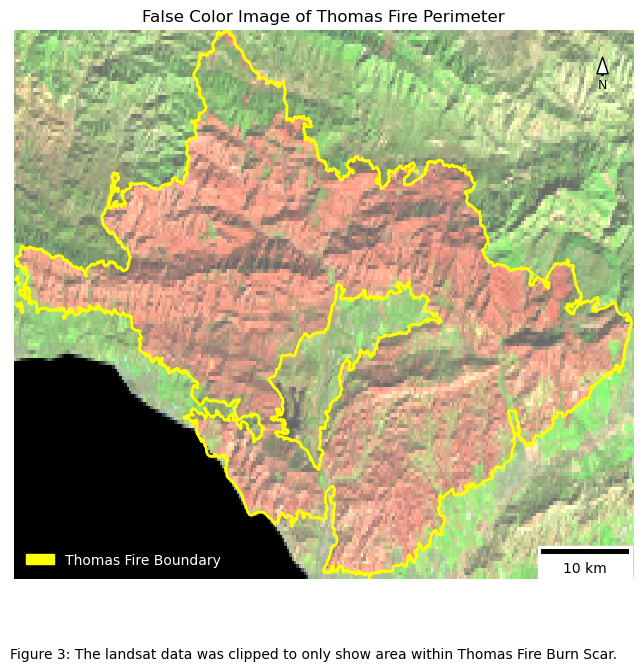

In [17]:
# Clip raster to area of interest
landsat_small = landsat.rio.clip_box(*thomas_fire.total_bounds)

# Initialize plot
fig, ax = plt.subplots(figsize = (8, 6*landsat_aspect_ratio))

# Remove axis
ax.axis('off')

# Overlay thomas_fire polygon
thomas_fire.plot(ax = ax,
                 color = 'none',
                edgecolor = 'yellow', 
                linewidth = 2)

# Plot shortwave infrared, near infrared, and red bands of landsat data. 
landsat_small[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, 
                                                           robust = True)

# Set title
ax.set_title('False Color Image of Thomas Fire Perimeter')

# Add a scale bar to map
scalebar = ScaleBar(1,  # Scale in units per pixel
                    units='m',  # Units of the scale bar (meters)
                    location='lower right',  # Position of the scale bar
                    scale_loc='bottom')  

# Add scalebar created above to plot
ax.add_artist(scalebar)

# Add a legend for the thomas_fire boundary
ax.legend(handles = [mpatches.Patch(color='yellow',
                          label='Thomas Fire Boundary')], 
          loc = "lower left",
          labelcolor = "white", 
          frameon=False)

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.9),
            arrowprops=dict(facecolor='white', width=1, headwidth=8),
            ha='center', va='center', fontsize=9, color='black',
            xycoords='axes fraction')

# Add figure description
plt.figtext(0.5, 0, "Figure 3: The landsat data was clipped to only show area within Thomas Fire Burn Scar.", wrap=True, horizontalalignment='center', fontsize=10)
